# Learning What Affects Hotel Reviews

In [1]:
import warnings
warnings.filterwarnings("ignore")
import os.path
from os import path
import pandas as pd
import spacy
import gensim 
from os import listdir
from tqdm import tqdm
import numpy as np
import random
import codecs
from sklearn.decomposition import PCA
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans 
import subprocess 
import os
import re
import string
from os.path import isfile, join
import logging
import pickle
import multiprocessing
from sklearn.metrics import pairwise_distances_argmin_min
from scipy import spatial
import matplotlib.pyplot as plt
import time
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import xgboost as xgb
from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder 
from xgboost import XGBClassifier
import gensim.downloader as api
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.neural_network import MLPClassifier
from wordcloud import WordCloud, STOPWORDS
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import AdaBoostClassifier
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import AdaBoostRegressor


In [2]:
cores = multiprocessing.cpu_count() 
print("Using", cores, "cores.")
# nltk.download()


Using 8 cores.


## TO-DO

* Fix google model (when loading it from cache)
* Cite https://www.kaggle.com/charlessamuel/trip-advisor-hotel-reviews-bert on visuallization part

## Hyper-Parameters

In [3]:
word2vec_embedding_size = 100  # Google uses dim = 300
use_cache = True
use_pretrained_google_model = False
sentiment_mode = False 

mode = 'regression'  # 'regression' / 'classification'
balanced_classes = True 
visualization = True

emb_agg = 'sif'  # 'sif' / 'sum' / 'mean'


# Datasets

In [4]:
data = pd.read_csv("../data/tripadvisor_hotel_reviews.csv")
print("Dataset size:", len(data))
data.head()


Dataset size: 20491


,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


## Visualization 

In [5]:
summ, total = 0, 0
for rev in data.Review.values:
    summ += len(rev.split(" "))
    total += 1
print("Avg. len for review:", summ/total)


Avg. len for review: 106.3750427016739


<AxesSubplot:xlabel='Rating', ylabel='count'>

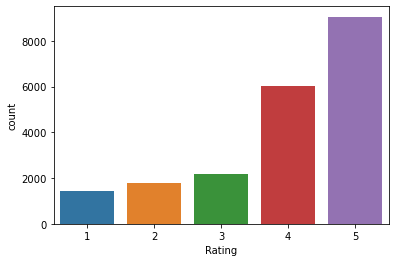

In [6]:
sns.countplot(data=data,x='Rating')


,Word,Count
0,hotel,42079
1,not,30750
2,room,30532
3,great,18732
4,n't,18436
5,staff,14950
6,good,14791
7,did,13433
8,just,12458
9,stay,11376


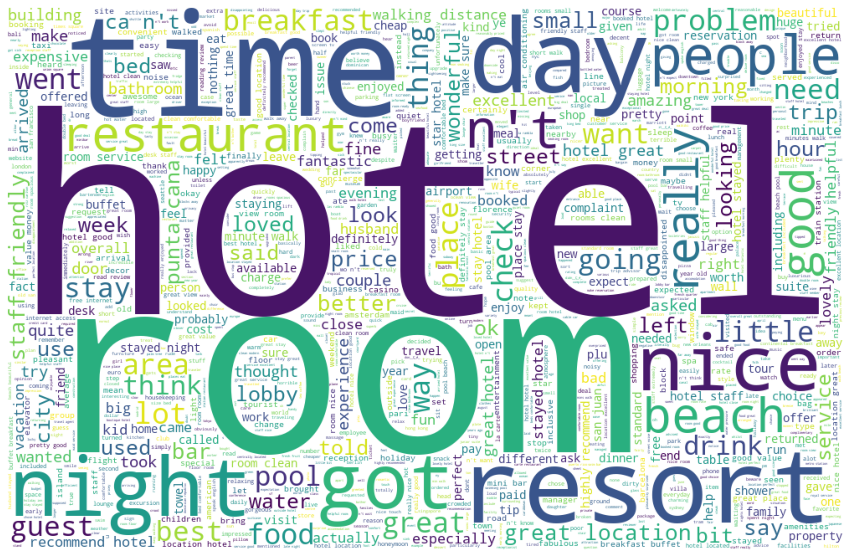

In [7]:
if visualization:
    word_list = []
    for sent in data['Review'].values:
        word_list += sent.split(" ")
    word_list = [word for word in word_list if word != '']
    words_collection = Counter(word_list)
    freq_word_df = pd.DataFrame(words_collection.most_common(15))
    freq_word_df.columns = ['Word','Count']
    display(freq_word_df.style.background_gradient(cmap='PuBuGn', low=0, high=0, axis=0, subset=None))
    
    word_string = " ".join(word_list)
    wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', max_words=60000, width=1000, height=650).generate(word_string)
    plt.figure(figsize=(20,10))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

# Sentiment Mode

In [8]:
# pos = [4, 5]
# neg = [1, 2]
# neu = [3]

# def sentiment(rating):
#     if rating in pos:
#         return 2
#     elif rating in neg:
#         return 0
#     else:
#         return 1  

# if sentiment_mode:
#     data['Rating'] = data['Rating'].apply(sentiment)
#     sns.countplot(data=data,x='Rating')


# Tokenizer

In [9]:
def clean_sentence(sent):
    sentence = sent.lower()   # lower case
    sentence = sentence.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(sentence)  # tokenizer
    stop_words = stopwords.words('english')
    tokens = [i for i in tokens if i not in stop_words] # stop words
    return tokens


def get_corpus(data):
    corpus = []
    reviews = data.Review.values
    for rev in tqdm(reviews):
        tokens = clean_sentence(rev)
        corpus.append(tokens)
    return corpus


def load_corpus(data, use_cache=True):
    corpus_path = '../cache/corpus.model'
    if not use_cache or not path.exists(corpus_path):
        corpus = get_corpus(data)
        with open(corpus_path, 'wb') as f:
            pickle.dump(corpus, f)
    else:
        with open(corpus_path, 'rb') as f:
            corpus = pickle.load(f)
    return corpus


### Load Corpus

In [10]:
corpus = load_corpus(data, use_cache)
print("Load corpus:", len(corpus))


Load corpus: 20491


# Word2Vec

In [11]:
if not use_pretrained_google_model:
    model_file = '../cache/word2vec.model'
    if not path.exists(model_file) or not use_cache:
        word2vec = gensim.models.Word2Vec(min_count=1,
                             window=5,
                             size=word2vec_embedding_size,
                             alpha=0.03, 
                             workers=cores-1)
        word2vec.build_vocab(corpus, progress_per=10000)
        word2vec.train(corpus, total_examples=word2vec.corpus_count, epochs=30, report_delay=1)
        word2vec.init_sims(replace=True)
        word2vec.save(model_file)  
    else:
        word2vec = gensim.models.Word2Vec.load(model_file)
        
else:
    model_file = '../cache/word2vec_google.model'
    if not path.exists(model_file) or not use_cache:
        word2vec = api.load('word2vec-google-news-300')
        word2vec.save(model_file)
    else:
        word2vec = gensim.models.Word2Vec.load(model_file)
        

# Review2Vec

From the article: https://openreview.net/pdf?id=SyK00v5xx

In [12]:
def sif_embeddings(sentences, model, alpha=1e-3):
    REAL = np.float32 
    vlookup = model.wv.vocab  # Gives us access to word index and count
    vectors = model.wv        # Gives us access to word vectors
    size = model.vector_size  # Embedding size
    
    Z = 0
    for k in vlookup:
        Z += vlookup[k].count # Compute the normalization constant Z
    
    output = []
    
    # Iterate all sentences
    for s in tqdm(sentences):
        count = 0
        v = np.zeros(size, dtype=REAL) # Summary vector
        # Iterare all words
        for w in s:
            # A word must be present in the vocabulary
            if w in vlookup:
                for i in range(size):
                    v[i] += ( alpha / (alpha + (vlookup[w].count / Z))) * vectors[w][i]
                count += 1 
                
        if count > 0:
            for i in range(size):
                v[i] *= 1/count
        output.append(v)
    return np.vstack(output).astype(REAL)


### Get Reviews Embeddings

In [13]:
if use_pretrained_google_model:
    model_file = '../cache/reviews_embeddings_google.pkl'
else:
    model_file = '../cache/reviews_embeddings.pkl'
    

In [14]:
if path.exists(model_file) and use_cache:
    with open(model_file, 'rb') as f:
        reviews_embeddings = pickle.load(f)      
else:
    reviews_embeddings = sif_embeddings(corpus, word2vec)
    with open(model_file, 'wb') as f:
        pickle.dump(reviews_embeddings, f)

print("Load embedding:", reviews_embeddings.shape)


Load embedding: (20491, 100)


In [15]:
# if emb_agg == 'mean':
#     print("Agg Embeddings: Mean")
#     reviews_embeddings = []
#     for s in tqdm(corpus):
#         vecs = []
#         for w in s:
#             vecs.append(word2vec[w])
#         reviews_embeddings.append(np.mean(vecs, axis=0))

        
# if emb_agg == 'sum':
#     print("Agg Embeddings: Sum")
#     reviews_embeddings = []
#     for s in tqdm(corpus):
#         vecs = []
#         for w in s:
#             vecs.append(word2vec[w])
#         reviews_embeddings.append(np.sum(vecs, axis=0))


# Model

In [16]:
X = pd.DataFrame.from_records(reviews_embeddings)
y = data.Rating.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
X_train.head()


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
19272,-0.016695,-0.017437,-0.011156,-0.005930,0.032896,-0.027146,0.000274,0.015120,-0.022308,0.021299,...,-0.000447,-0.022479,-0.006303,-0.015264,-0.005486,-0.027162,0.000050,-0.007806,-0.007285,-0.002395
5699,-0.005565,0.007752,0.032760,-0.022398,-0.005128,-0.020819,-0.004764,-0.013767,0.004781,0.000060,...,-0.011075,-0.005086,-0.002063,0.019925,0.005459,-0.003051,0.015780,0.014188,0.016251,0.024276
10341,-0.002393,-0.020457,-0.001118,-0.005255,0.021796,-0.017685,-0.004352,-0.012995,-0.012430,-0.005172,...,0.007984,-0.046840,-0.002958,-0.015523,0.012182,0.001805,-0.009534,0.031284,-0.000967,0.000361
14991,0.009397,-0.010818,0.003572,-0.001280,0.022414,-0.018391,0.016204,-0.033556,-0.007655,0.029237,...,0.007052,-0.022979,0.013826,-0.036313,-0.016082,-0.008605,-0.027092,-0.031115,-0.022999,0.007437
17879,-0.061994,0.002819,-0.014958,-0.002805,-0.017840,-0.019195,-0.001870,-0.041422,-0.052019,-0.073693,...,-0.010093,-0.032758,0.016853,-0.004435,0.036169,-0.031716,0.023588,-0.006540,0.022521,-0.021854


## XGBoost

### Hyper-Param Search

In [17]:
# model = XGBClassifier() 

# parameters = {'nthread':[4],
#               'objective':['multi:softmax'],
#               'learning_rate': [0.05, 0.01, 0.001, 0.005], 
#               'max_depth': [3, 4, 5, 6, 7],
#               'min_child_weight': [1, 2, 3, 5, 7],
#               'colsample_bytree': [0.2, 0.3, 0.5],
#               'n_estimators': [300, 500, 750, 1000]}


# clf = GridSearchCV(model, parameters, n_jobs=-1, 
#                    cv=StratifiedKFold(n_splits=3, shuffle=True), 
#                    scoring='accuracy',
#                    verbose=2, refit=True)

# clf.fit(X_train, y_train)

# print(clf.best_params_)


### Model

In [18]:
if mode == 'classification':
    #     model = XGBClassifier(
    #         colsample_bytree = 0.2,
    #         learning_rate = 0.005,
    #         max_depth = 10,
    #         min_child_weight = 3,
    #         n_estimators = 1000,
    #         nthread = 4,
    #         # objective = 'multi:softmax'
    #     ) 
    model = LogisticRegression(C=50000, solver='newton-cg')
    # model = AdaBoostClassifier()
    # model = MLPClassifier(random_state=1, max_iter=500)

else: 
#     model = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree=0.1, learning_rate=0.01,
#                        max_depth=2, alpha=10, n_estimators=600)
    model = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree=1, n_estimators=300, max_depth=4,
                             subsample=0.8, gamma=0)
    # model = AdaBoostRegressor(random_state=0, n_estimators=100)
    # model = linear_model.LinearRegression()
    

### Balanced Dataset

In [19]:
if balanced_classes: 
    print("Created balanced train dataset")   
    smote = SMOTE()
    X_train, y_train = smote.fit_resample(X_train, y_train)
    

Created balanced train dataset


### Fit

In [20]:
model.fit(X_train, y_train)


[18:20:38] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=8, num_parallel_tree=1,
             objective='reg:linear', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=0.8, tree_method='exact',
             validate_parameters=1, verbosity=None)

### Predict 

In [21]:
y_pred = model.predict(X_test) 
predictions = [round(value) for value in y_pred]
for ii, p in enumerate(predictions):
    if p < 1: predictions[ii] = 1 
    if p > 5: predictions[ii] = 5
        

In [22]:
y_pred[0:10]


array([4.094218 , 2.9586458, 4.355986 , 4.1460996, 5.292487 , 5.5031676,
       4.9710994, 4.111879 , 4.3616204, 3.0437331], dtype=float32)

### Evaluation - Test results

In [23]:
accuracy = accuracy_score(y_test, predictions) 
print("Accuracy: %.2f%%" % (accuracy * 100.0))
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE: %.3f" % (rmse))
print(classification_report(y_test, predictions))


Accuracy: 50.31%
RMSE: 0.832
              precision    recall  f1-score   support

           1       0.66      0.40      0.50       445
           2       0.38      0.43      0.41       524
           3       0.26      0.44      0.33       631
           4       0.44      0.53      0.48      1890
           5       0.74      0.53      0.62      2658

    accuracy                           0.50      6148
   macro avg       0.49      0.47      0.46      6148
weighted avg       0.56      0.50      0.52      6148



### Train Results 

In [24]:
train_pred = model.predict(X_train) 
rmse_train = mean_squared_error(y_train, train_pred, squared=False)
train_predictions = [round(value) for value in train_pred]
for ii, p in enumerate(train_predictions):
    if p < 1: train_predictions[ii] = 1
    if p > 5: train_predictions[ii] = 5
train_accuracy = accuracy_score(y_train, train_predictions) 
print("Accuracy: %.2f%%" % (train_accuracy * 100.0))
print("RMSE: %.3f" % (rmse_train))
print(classification_report(y_train, train_predictions))


Accuracy: 79.41%
RMSE: 0.422
              precision    recall  f1-score   support

           1       0.97      0.87      0.92      6396
           2       0.80      0.83      0.81      6396
           3       0.74      0.81      0.77      6396
           4       0.65      0.77      0.71      6396
           5       0.87      0.70      0.77      6396

    accuracy                           0.79     31980
   macro avg       0.81      0.79      0.80     31980
weighted avg       0.81      0.79      0.80     31980



# Counterfactual Examples

TO-DO:
* remove sent with zero score (N)
* add window size 

In [25]:
POS_ADJS = ["good", "nice", "great"]
NEG_ADJS = ["bad", "awful"]

def find_sentences_with_concepts(review, concepts):
    sentences_list = re.split('\.|,|\?|!|;|:', review)
    return [sentence for sentence in sentences_list if all([concept in sentence for concept in concepts])]

def gen_counter_sentence(concept, is_positive):
    adj = random.choice(POS_ADJS) if is_positive else random.choice(NEG_ADJS)
    return "{} is {}".format(concept, adj)

def gen_synthetic_counter_examples(data, concept):
    reviews = data.Review.values
    original_reviews = []
    counter_reviews = []
    neutral_reviews = []
    concept_conotation = []
    reviews_score = []
    reviews_idx = []
   
    sia = SentimentIntensityAnalyzer()
    concepts = concept.split(" ")
    
    for review_idx, review in enumerate(reviews):
        sentences = find_sentences_with_concepts(review, concepts)
        if len(sentences) >= 1:
            counter_review = review
            neutral_review = review
            
            # find the rigth treatment
            all_scores =  [sia.polarity_scores(sentence)["compound"] for sentence in sentences]
            abs_scores = list(map(abs, all_scores)) 
            max_idx = abs_scores.index(max(abs_scores))
            max_score = all_scores[max_idx]   # with a sign
            
            if max_score > 0:   # t = 1: positive
                T = 1
            else:
                T = 0
                
            for sentence in sentences:
                scores = sia.polarity_scores(sentence)                
                if T == int(scores["compound"] > 0):   # t = 1: positive
                    counter_sentence = gen_counter_sentence(concept, not T)
                    counter_review = counter_review.replace(sentence, counter_sentence)
                
                neutral_review = neutral_review.replace(sentence, "")
               
            original_reviews.append(review)
            counter_reviews.append(counter_review)
            neutral_reviews.append(neutral_review)
            concept_conotation.append(T)
            reviews_score.append(data.Rating.values[review_idx])
            reviews_idx.append(review_idx)
               
    return (original_reviews, counter_reviews, neutral_reviews, concept_conotation, reviews_score, reviews_idx)


## Concept - Room Size

In [26]:
# concept = "room size"
concept = "breakfast"
original_reviews, counter_reviews, neutral_reviews, concept_conotation, reviews_score, reviews_idx = gen_synthetic_counter_examples(data, concept)

In [27]:
df = pd.DataFrame(list(zip(original_reviews, counter_reviews, neutral_reviews, concept_conotation, reviews_score, reviews_idx)), columns =['Original', 'Counterfactual', 'Neutral', 'Treatment', 'Score', 'Reviews Index'])
test_indices = X_test.index.values   # filltering the train set from the predictions 
df = df[df['Reviews Index'].isin(test_indices)].reset_index(drop=True)
df['Treatment'] = df['Treatment'].astype(int)
df

,Original,Counterfactual,Neutral,Treatment,Score,Reviews Index
0,nice hotel husband stayed warwick 4 years ago ...,nice hotel husband stayed warwick 4 years ago ...,nice hotel husband stayed warwick 4 years ago ...,0,4,28
1,"nice hotel trip seattle wanted stay downtown, ...","nice hotel trip seattle wanted stay downtown, ...","nice hotel trip seattle wanted stay downtown, ...",1,4,35
2,"ace hotel awesome, stayed seattle ace hotel 5 ...","ace hotel awesome, stayed seattle ace hotel 5 ...","ace hotel awesome, stayed seattle ace hotel 5 ...",1,5,72
3,"great stay elevators, agree previous posts hot...","great stay elevators, agree previous posts hot...","great stay elevators, agree previous posts hot...",1,5,82
4,good location value downtown stayed town confe...,good location value downtown stayed town confe...,good location value downtown stayed town confe...,1,4,85
...,...,...,...,...,...,...
2309,"wonderful loved hotel, brand new opened februa...","wonderful loved hotel, brand new opened februa...","wonderful loved hotel, brand new opened februa...",1,5,20443
2310,"wonderful resort off-season gem, just returned...","wonderful resort off-season gem, just returned...","wonderful resort off-season gem, just returned...",1,5,20463
2311,"loved la concha, stayed 2 nights 3 days la con...","loved la concha, stayed 2 nights 3 days la con...","loved la concha, stayed 2 nights 3 days la con...",1,5,20464
2312,"great hotel rooms large unfortunately no view,...","great hotel rooms large unfortunately no view,...","great hotel rooms large unfortunately no view,...",0,4,20472


# ITE

In [28]:
def get_pred_sample(model, df, idx, mode):
    sample = df.iloc[idx][mode] 
    tokens = clean_sentence(sample)
    vec = sif_embeddings([tokens], word2vec)
    # pred = model.predict(vec)[0]
    pred = model.predict(pd.DataFrame(vec))[0]
    return pred

def get_scores_sample(model, df, idx):
    v1 = get_pred_sample(model, df, idx, 'Original')
    v2 = get_pred_sample(model, df, idx, 'Counterfactual')
    v3 = get_pred_sample(model, df, idx, 'Neutral')
    return v1, v2, v3

In [39]:
ite_file = '../cache/ite_res_' + concept + '.pkl'

if path.exists(ite_file) and use_cache:
    with open(ite_file, 'rb') as f:
        ite_res = pickle.load(f)      
else:
    ite_res = df.copy()
    score1, score2, score3 = [], [], []
    for idx in range(len(ite_res)):
        v1, v2, v3 = get_scores_sample(model, df, idx)
        score1.append(v1)
        score2.append(v2)
        score3.append(v3)
    ite_res = ite_res.rename(columns={'Score': 'True Score'})
    ite_res['Original Score'] = score1
    ite_res['Counterfactual Score'] = score2
    ite_res['Neutral Score'] = score3
    
    with open(ite_file, 'wb') as f:
        pickle.dump(ite_res, f)

In [40]:
ite_df = ite_res[['True Score', 'Treatment', 'Original Score', 'Counterfactual Score', 'Neutral Score']]
ite_df

,True Score,Treatment,Original Score,Counterfactual Score,Neutral Score
0,4,0,4.260885,4.431441,4.212358
1,4,1,4.466630,4.130929,4.276947
2,5,1,5.063028,4.188135,4.424317
3,5,1,2.468509,2.032967,1.848918
4,4,1,5.022184,4.467602,4.271729
...,...,...,...,...,...
2309,5,1,5.072253,5.153506,5.256711
2310,5,1,4.591588,4.593317,4.598371
2311,5,1,5.362794,5.258464,5.233812
2312,4,0,4.466868,3.955922,3.920616


In [41]:
t1 = ite_df[ite_df['Treatment'] == 1]
t0 = ite_df[ite_df['Treatment'] == 0]

ite_t1 = t1['Original Score'] - t1['Counterfactual Score']
ite_t0 = t0['Counterfactual Score'] - t0['Original Score'] 

print("ITE -" , concept, ":", np.mean(ite_t1) + np.mean(ite_t0))

ITE - breakfast : 0.16973207668919282


In [42]:
np.mean(t1['Original Score'] - t1['Neutral Score'])

0.022013156091349628

In [44]:
np.mean(t0['Original Score'] - t0['Neutral Score'])

-0.028901263951680283